# **Megafon course work**

# Importing librarys

In [1]:
!pip install dask[complete]

In [2]:
import os
import dill
import pandas as pd
import numpy as np
import dask.dataframe as dd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier

import matplotlib.pyplot as plt

# Prepare data

In [3]:
PATH_TRAIN = '../input/d/konstantinalbul/megafon-course-work/data_train.csv'
PATH_TEST = '../input/d/konstantinalbul/megafon-course-work/data_test.csv'
PATH_FEATURES = '../input/d/konstantinalbul/megafon-course-work/features.csv/features.csv'

### Let's cut features dataframe with users from train and test

In [4]:
# %%time

df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

CPU times: user 471 ms, sys: 92.4 ms, total: 563 ms
Wall time: 1.03 s


In [5]:
# %%time

df_features = dd.read_csv(PATH_FEATURES, sep='\t')

common_users = pd.concat([df_train, df_test]).id.unique()
df_features = df_features[df_features.id.isin(common_users)].compute()
del common_users

df_features.drop('Unnamed: 0', axis=1, inplace=True)
df_features.head(2)

CPU times: user 8min 29s, sys: 1min 19s, total: 9min 48s
Wall time: 4min 18s


,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
13,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


### Merge data from features dataframe to train/test

In [6]:
def transform(df: pd.DataFrame, df_features: pd.DataFrame, isTrain: bool) -> pd.DataFrame:
    print(f"Shape before transform: {df.shape}")
    
    df = pd.merge(df, df_features, how='left', on='id')
    
    # let's discard the rows where the event from the `df_features` is 2 days later or early then in `df`
    if isTrain:
        df = df[abs(df.buy_time_x - df.buy_time_y) > 172800]
    
    df.drop(['Unnamed: 0', 'buy_time_y'], axis=1, inplace=True)
    df.rename(columns={"buy_time_x": "buy_time"}, inplace=True)
    
    print(f"Shape after transform: {df.shape}")
    return df

### Grouping features by `id` and take first row

In [7]:
# %%time

df_features_groupby = df_features.groupby('id').first()

CPU times: user 10.2 s, sys: 7.52 s, total: 17.7 s
Wall time: 17.7 s


In [8]:
# %%time

df_train = transform(df_train, df_features_groupby, True)
df_train.head(2)

Shape before transform: (831653, 5)
Shape after transform: (793804, 257)
CPU times: user 3.57 s, sys: 2.62 s, total: 6.19 s
Wall time: 6.19 s


,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,1537131600,0.0,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,1531688400,0.0,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0


In [9]:
# %%time

df_test = transform(df_test, df_features_groupby, False)
df_test.to_csv('./data_test.csv')
df_test.head(2)

Shape before transform: (71231, 4)
Shape after transform: (71231, 256)
CPU times: user 37.7 s, sys: 1.13 s, total: 38.8 s
Wall time: 38.8 s


,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,3130519,2.0,1548018000,-62.899971,-374.279112,-72.600786,-418.406798,-78.018246,-439.51179,17.81382,...,-970.373846,-613.770792,-25.996269,-37.630448,-258.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2000860,4.0,1548018000,-96.799971,100.290888,-110.740786,140.903202,-116.158246,119.79821,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-254.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


# Split dataset

In [10]:
RANDOM_STATE = 100

In [11]:
def get_features(X: pd.DataFrame):
    assert isinstance(X, pd.DataFrame)
    
    X_nunique = X.apply(lambda x: x.nunique(dropna=False))

    f_init = set(X_nunique.index.tolist())
    f_const = set(X_nunique[X_nunique == 1].index.tolist())
    f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
    f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
    f_other = f_init - (f_numeric | f_const)
    f_binary = set(X.loc[:, f_other].columns[(
        (X.loc[:, f_other].max() == 1) & \
        (X.loc[:, f_other].min() == 0) & \
        (X.loc[:, f_other].isnull().sum() == 0)
    )])
    f_other = f_other - f_binary
    f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
    f_other = f_other - f_categorical
    f_numeric = f_numeric | f_other
    f_all = f_binary | f_categorical | f_numeric

    print('f_init:', len(f_init))
    print('f_const:', len(f_const))
    print('f_binary:', len(f_binary))
    print('f_categorical:', len(f_categorical))
    print('f_numeric:', len(f_numeric))
    
    assert(len(f_init) == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

    return list(f_binary), list(f_categorical), list(f_numeric), list(f_all)

In [12]:
# %%time

X = df_train.drop(['id', 'target'], axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=100,
    shuffle=True,
    stratify=y,
)

f_binary, f_categorical, f_numeric, f_all = get_features(X_train)
del df_train, X, y

f_init: 255
f_const: 5
f_binary: 0
f_categorical: 1
f_numeric: 249
CPU times: user 7.15 s, sys: 3.51 s, total: 10.7 s
Wall time: 10.7 s


# Compare different models

In [13]:
def evaluate_model(model, X_test, y_test):
    y_test_pred = model.predict_proba(X_test)[:,1]
    print(f'{classification_report(y_test, y_test_pred > 0.5)}\n\n')

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        assert isinstance(X, pd.DataFrame)
        
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame does not contain the following columns: %s" % cols_error)

In [15]:
# %%time

train_pipeline = make_pipeline(
    FeatureSelector(columns=f_all),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            FeatureSelector(columns=f_numeric),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            FeatureSelector(columns=f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ]),
    SelectFromModel(LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')),
)

models = {
    0: {
        'name': 'LogisticRegression',
        'estimator': LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
        ),
    },
    1: {
        'name': 'SGDClassifier',
        'estimator': SGDClassifier(
            random_state=RANDOM_STATE,
            loss='log',
        ),
    },
    2: {
        'name': 'GradientBoostingClassifier',
        'estimator': GradientBoostingClassifier(
            random_state=RANDOM_STATE,
        )
    },
}

for key,value in models.items():
    
    print(f'{models[key]["name"]}')
    model = make_pipeline(
        train_pipeline,
        models[key]["estimator"],
    )
    model.fit(X_train, y_train)
    
    evaluate_model(model, X_test, y_test)

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    184026
         1.0       0.29      0.00      0.00     14425

    accuracy                           0.93    198451
   macro avg       0.61      0.50      0.48    198451
weighted avg       0.88      0.93      0.89    198451



SGDClassifier
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    184026
         1.0       0.38      0.01      0.02     14425

    accuracy                           0.93    198451
   macro avg       0.65      0.51      0.49    198451
weighted avg       0.89      0.93      0.89    198451



GradientBoostingClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    184026
         1.0       0.67      0.27      0.38     14425

    accuracy                           0.94    198451
   macro avg       0.81      0.63      0.68    198451
weighted a

# Final model training

In [16]:
# %%time

final_model = make_pipeline(
    train_pipeline,
    GradientBoostingClassifier(
        random_state=RANDOM_STATE,
        learning_rate=0.3,
        n_estimators=300,
        min_samples_split=2,
        max_depth=8,
    )
)

final_model.fit(X_train, y_train)

CPU times: user 1h 20min 3s, sys: 20.7 s, total: 1h 20min 24s
Wall time: 1h 20min 25s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('featureselector',
                                  FeatureSelector(columns=['99', '182', '215',
                                                           '193', '82', '83',
                                                           '118', '131', '144',
                                                           '192', '57', '208',
                                                           '220', '204', '71',
                                                           '31', '217', '191',
                                                           '61', '38', '213',
                                                           '35', '48', '126',
                                                           '5', '26', '45',
                                                           '140', '164', '42', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_

# Results

In [17]:
evaluate_model(final_model, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96    184026
         1.0       0.52      0.34      0.41     14425

    accuracy                           0.93    198451
   macro avg       0.73      0.66      0.68    198451
weighted avg       0.92      0.93      0.92    198451





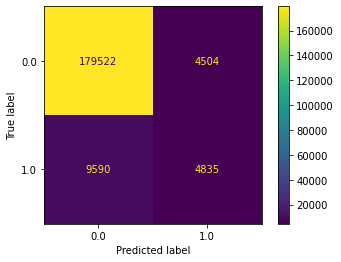

In [18]:
plot_confusion_matrix(final_model, X_test, y_test)
plt.show()

AUC_PR = 0.437
AUC_ROC = 0.917


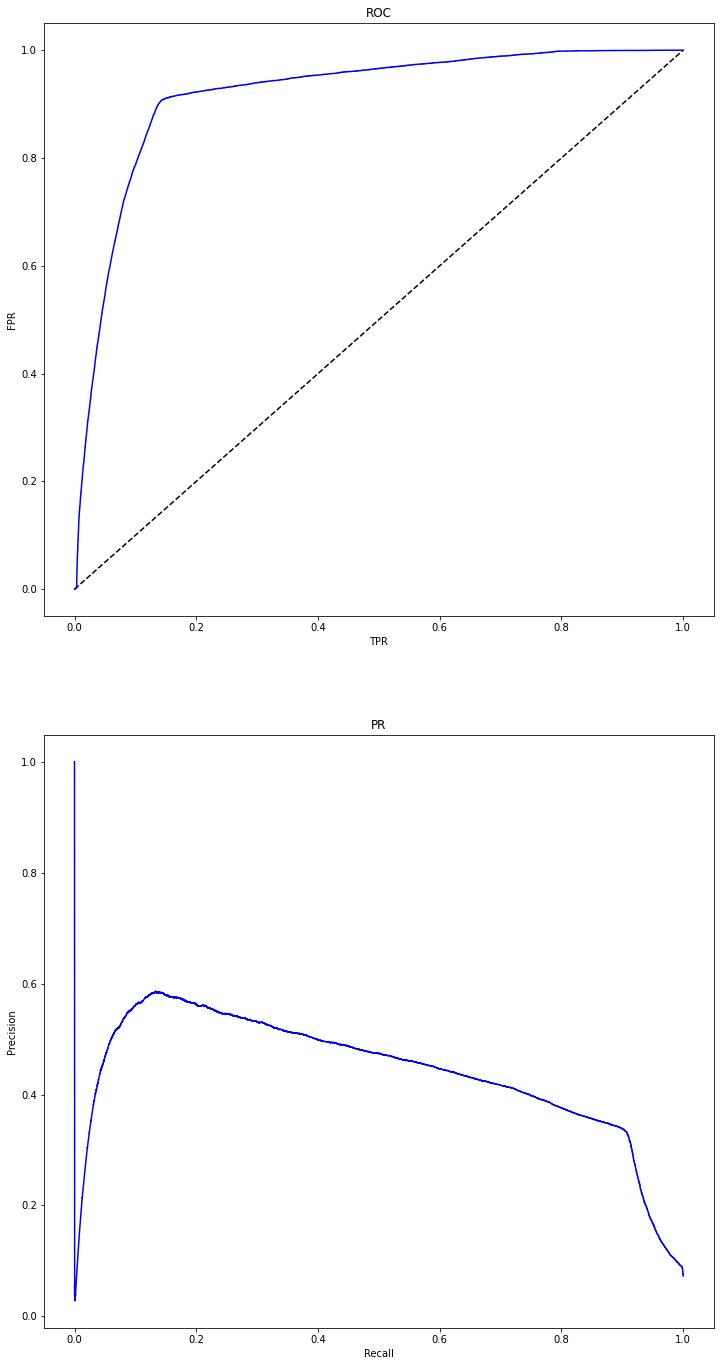

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')

ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

y_test_pred = final_model.predict_proba(X_test)[:,1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("AUC_PR = %.3f" % auc(recall, precision))
print("AUC_ROC = %.3f" % auc(fpr, tpr))

# Export pipeline

In [20]:
with open('pipeline.dill', 'wb') as file:
    dill.dump(final_model, file)